In [2]:
import sys
sys.path.append('../scripts/')

import glob
import warnings
import param

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='paper', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

%matplotlib inline

In [6]:
# probably also needs: jupyter labextension install @pyviz/jupyterlab_pyviz
# jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [73]:
def prepare_data(tms, ctd):
    ''' Procedure to calculate chi from EM-APEX float

    see: RC's write-up "EM-APEX Turbulence Measurements"
    '''

    # % 1) convert realtime-transmitted scaled spectrum (sla)
    # to digitized voltage Spectrum
    tms['slad1'] = (tms.sla1 - tms.logavgoff) / tms.logavgsf
    tms['slad2'] = (tms.sla2 - tms.logavgoff) / tms.logavgsf

    # % 2) convert to raw spectrum of temperature
    beta = 25
    Vref = 4  # volt
    Inet = 0.8
    scale2 = (beta * Vref / (2**23 * Inet))**2
    tms['rawTsp1'] = 10**(tms.slad1 / 10) * scale2
    tms['rawTsp2'] = 10**(tms.slad2 / 10) * scale2

    # % 3) get background T,N,P,W, and dT/dz from ctd
    tms['p'] = ctd.p.interp(time=tms.time)
    tms['N2'] = ctd.N2.interp(time=tms.time)
    tms['N'] = np.abs(np.sqrt(tms['N2']))
    tms['T'] = ctd.T.interp(time=tms.time)
    tms['dTdz'] = ctd.dTdz.interp(time=tms.time)
    tms['w'] = np.abs(ctd.w.interp(time=tms.time))

    # convert to wavenumber
    tms['k_cpm'] = tms.f_cps / tms.w
    tms['f_rps'] = tms.f_cps * 2 * np.pi
    tms['k_rpm'] = tms.f_rps / tms.w
    tms = tms.set_coords('k_rpm')

    # % 4) compute transfer functions and compute corrected T spectrum
    tms['H2adc'] = H2ADCfun(tms.f_cps)
    tms['H2preamp'] = H2preampfun(tms.f_cps)
    tms['H2fp07'] = H2FP07fun(tms.f_cps, tms.w)
    tms['H2total_cps'] = tms.H2adc * tms.H2preamp * tms.H2fp07
    tms['corrTsp1_cps'] = tms.rawTsp1 / tms.H2total_cps
    tms['corrTsp2_cps'] = tms.rawTsp2 / tms.H2total_cps
    
    # % 5) remove noise Spectrum
    #     threshold = 4
    #     tms = remove_noise_sp(tms, threshold) 
    
    tms['noise_cps'] = noise_sp(tms.f_cps)
    
    # compute signal-to-noise ratio
    tms['snr1'] = tms.corrTsp1_cps/tms.noise_cps
    tms['snr2'] = tms.corrTsp2_cps/tms.noise_cps

    # % 6) convert temperature frequency to wavenumber spectrum
    tms['corrTsp1_rpm'] = tms.corrTsp1_cps * tms.w / (2 * np.pi)
    tms['corrdTdzsp1_rpm'] = tms.k_rpm**2 * tms.corrTsp1_rpm

    tms['corrTsp2_rpm'] = tms.corrTsp2_cps * tms.w / (2 * np.pi)
    tms['corrdTdzsp2_rpm'] = tms.k_rpm**2 * tms.corrTsp2_rpm
    
    tms = tms.drop(
        ['slad1', 'slad2', 'rawTsp1', 'rawTsp2','logavgsf','logavgoff','sla1','sla2'])
    return tms

def compute_chi(tms, p):
    # % 7) compute chi, kT, and eps1    
    tms['noise_rpm'] = tms.k_rpm**2*tms.noise_cps*tms.w/(2*np.pi)
    
    tms = tms.swap_dims({'f_cps': 'k_rpm'})
    condition = (tms.k_rpm <= p.kzmax) & (tms.k_rpm >= p.kzmin)

    if condition.sum() >= 3:
        tms['chi1'] = 6 * p.D * (tms.corrdTdzsp1_rpm - tms.noise_rpm).where(condition).dropna(
            dim='k_rpm').integrate('k_rpm')
        tms['chi2'] = 6 * p.D * (tms.corrdTdzsp2_rpm - tms.noise_rpm).where(condition).dropna(
            dim='k_rpm').integrate('k_rpm')
        tms['isnr1'] = tms.snr1.where(condition).dropna(
            dim='k_rpm').integrate('k_rpm')
        tms['isnr2'] = tms.snr2.where(condition).dropna(
            dim='k_rpm').integrate('k_rpm')
    else:
        tms['chi1'] = np.nan
        tms['chi2'] = np.nan
        tms['isnr1'] = np.nan
        tms['isnr2'] = np.nan
        
    return tms

def compute_rc_eps(tms, p):
    ''' Assume mixing efficiency and compute eps using background dTdz, N2, and chi
    
    see Ren-Chieh's document, 1992
    '''
    tms['kt1'] = 0.5 * tms.chi1 / tms.dTdz**2
    tms['eps1_rc'] = tms.kt1 * tms.N2 / p.gamma
    tms['kb1_rc'] = (tms.eps1_rc / p.nu / p.D**2)**(0.25)
    
    tms['kt2'] = 0.5 * tms.chi2 / tms.dTdz**2
    tms['eps2_rc'] = tms.kt2 * tms.N2 / p.gamma
    tms['kb2_rc'] = (tms.eps2_rc / p.nu / p.D**2)**(0.25)

    return tms

def compute_goto_eps(tms, p):
    '''
    Method after Ruddick et al, 1996 and Goto et al., 2016
    
    Requires computation of chi.
    '''
    def cost_function(kb, k_rpm, chi, noise, corrdTdz, function, p):
        '''
        Cost function for MLE to fit spectra
        '''
        from scipy.stats import chi2

        if function.lower() == 'batchelor':
            theory = batchelor(k_rpm, chi, kb, p)
        elif function.lower() == 'kraichnan':
            theory = kraichnan(k_rpm, chi, kb, p)
        elif function.lower() == 'powerlaw':
            theory = powerlaw(k_rpm, chi, kb, p)
        else:
            raise ValueError('Function not known!')

        a = p.dof / (theory + noise)
        b = chi2.pdf(corrdTdz * a, p.dof)
        c = np.log(a * b)

        return -np.nansum(c)
    
    condition = (tms.k_rpm <= p.kzmax) & (tms.k_rpm >= p.kzmin)

    chi1 = tms.where(condition).chi1.values
    chi2 = tms.where(condition).chi2.values
    noise = tms.where(condition).noise_rpm.values
    k_rpm = tms.where(condition).k_rpm.values
    dtdz1 = tms.where(condition).corrdTdzsp1_rpm.values
    dtdz2 = tms.where(condition).corrdTdzsp2_rpm.values

    args = (k_rpm, chi1, noise, dtdz1, 'Batchelor', p)
    tms['kb1_bat'] = minimize(cost_function, x0=p.x0, args=args).x[0]
    args = (k_rpm, chi2, noise, dtdz2, 'Batchelor', p)
    tms['kb2_bat'] = minimize(cost_function, x0=p.x0, args=args).x[0]

    args = (k_rpm, chi1, noise, dtdz1, 'Kraichnan', p)
    tms['kb1_kra'] = minimize(cost_function, x0=p.x0, args=args).x[0]
    args = (k_rpm, chi2, noise, dtdz2, 'Kraichnan', p)
    tms['kb2_kra'] = minimize(cost_function, x0=p.x0, args=args).x[0]
    
    tms['eps1_bat'] = tms['kb1_bat']**4 * p.nu * p.D**2
    tms['eps2_bat'] = tms['kb2_bat']**4 * p.nu * p.D**2  #* (2 * np.pi)**4

    tms['eps1_kra'] = tms['kb1_kra']**4 * p.nu * p.D**2
    tms['eps2_kra'] = tms['kb2_kra']**4 * p.nu * p.D**2
    
    return tms

def qc_rc_eps(data, p):
    '''
    clean chi and eps with RC's scripts
    '''
    
    # for ratios
    lb = 0.5
    ub = 2

    floats = np.array([
        '7779a', '7781a', '7783a', '7786a', '7787a', '7788a',
        '7700b', '7701b','7780b', '7784b', '7785b', '7786b'
    ])
    fi = np.where(floats == data.floatid)[0][0]
    good_chi1, good_chi2 = np.load('../data/good_chi.npy')

    # 1) thresholds for chi
    data['dtdz1'] = np.sqrt(0.5 * data.chi1 / data.kt1)
    data['dtdz2'] = np.sqrt(0.5 * data.chi2 / data.kt2)

    bad = (data.dtdz1 <= p.dtdzmin) | (data.chi1 >= p.chimax) | (data.kt1 >= p.kTmax) #| (data.z > zmin)
    data['chi1'] = data['chi1'].where(~bad)
    data['kt1'] = data['kt1'].where(~bad)
    data['eps1_rc'] = data['eps1_rc'].where(~bad)

    bad = (data.dtdz2 <= p.dtdzmin) | (data.chi2 >= p.chimax) | (data.kt2 >= p.kTmax) #| (data.z > zmin)
    data['chi2'] = data['chi2'].where(~bad)
    data['kt2'] = data['kt2'].where(~bad)
    data['eps2_rc'] = data['eps2_rc'].where(~bad)

    # 2) periods of functioning chi sensor
    tmin, tmax = str2date(good_chi1[fi, 0]), str2date(good_chi1[fi, 1])
    bad = (data.time < tmin) | (data.time > tmax)
    data['chi1'] = data['chi1'].where(~bad)
    data['kt1'] = data['kt1'].where(~bad)
    data['eps1_rc'] = data['eps1_rc'].where(~bad)

    tmin, tmax = str2date(good_chi2[fi, 0]), str2date(good_chi2[fi, 1])
    bad = (data.time < tmin) | (data.time > tmax)
    data['chi2'] = data['chi2'].where(~bad)
    data['kt2'] = data['kt2'].where(~bad)
    data['eps2_rc'] = data['eps2_rc'].where(~bad)

    # 3) compare two sensors
    def combine_fun(array1, array2, lb=lb, ub=ub):
        ratio = array1 / array2
        bad = (ratio <= lb) | (ratio >= ub)

        chi1fin = np.isfinite(array1)
        chi2fin = np.isfinite(array2)

        a1 = np.minimum(array1.where(bad & chi1fin),
                        array2.where(bad & chi1fin))
        a2 = np.minimum(array1.where(bad & chi2fin),
                        array2.where(bad & chi2fin))
        a3 = avg_funs(array1.where(~bad), array2.where(~bad))

        concat = xr.concat([a1, a2, a3], dim='temp')
        return concat.mean(dim='temp')

    data['kT'] = combine_fun(data.kt1, data.kt2)
    data['chi'] = combine_fun(data.chi1, data.chi2)
    data['eps_rc'] = combine_fun(data.eps1_rc, data.eps2_rc)

    data = data.drop(
        ['eps1_rc', 'eps2_rc', 'kt1', 'kt2', 'dtdz1', 'dtdz2'])
    return data

def mad(tms, p):
    ''' Compute Maximum Absolute Deviation
    (here based on mean) and averaged for wavenumbers where SNR is large
    '''
    
    def max_abs_dev(ds):
        import bottleneck as bn
        return bn.nanmean( np.abs( ds  - bn.nanmean(ds)) )
    
    condition = (tms.k_rpm <= p.kzmax) & (tms.k_rpm >= p.kzmin)
    
    th_bat1 = batchelor(tms.k_rpm, tms.chi1, tms.kb1_bat, p) + tms.noise_rpm
    th_bat2 = batchelor(tms.k_rpm, tms.chi2, tms.kb2_bat, p) + tms.noise_rpm
    
    th_kra1 = kraichnan(tms.k_rpm, tms.chi1, tms.kb1_kra, p) + tms.noise_rpm
    th_kra2 = kraichnan(tms.k_rpm, tms.chi2, tms.kb2_kra, p) + tms.noise_rpm
    
    th_rc1 = batchelor(tms.k_rpm, tms.chi1, tms.kb1_rc, p) + tms.noise_rpm
    th_rc2 = batchelor(tms.k_rpm, tms.chi2, tms.kb2_rc, p) + tms.noise_rpm
    
    ratio_bat1 = (tms.corrdTdzsp1_rpm/th_bat1).where(condition)
    ratio_bat2 = (tms.corrdTdzsp2_rpm/th_bat2).where(condition)
    ratio_kra1 = (tms.corrdTdzsp1_rpm/th_kra1).where(condition)
    ratio_kra2 = (tms.corrdTdzsp2_rpm/th_kra2).where(condition)
    ratio_rc1 = (tms.corrdTdzsp1_rpm/th_rc1).where(condition)
    ratio_rc2 = (tms.corrdTdzsp2_rpm/th_rc2).where(condition)
    
    tms['mad1_bat'] = max_abs_dev( ratio_bat1 )
    tms['mad2_bat'] = max_abs_dev( ratio_bat2 )
    
    tms['mad1_kra'] = max_abs_dev( ratio_kra1 )
    tms['mad2_kra'] = max_abs_dev( ratio_kra2 )
    
    tms['mad1_rc'] = max_abs_dev( ratio_rc1 )
    tms['mad2_rc'] = max_abs_dev( ratio_rc2 )
    return tms

In [ ]:
def powerlaw()

In [74]:
chi_dir = '../data/chi/ema-'+l+'-tms.mat'
tms = convert_tmsdata(chi_dir)
ctd_dir = '../data/chi/ema-'+l+'-ctd.mat'
ctd = convert_ctddata(ctd_dir)

tms_block = tms.isel(time=20)

tms_block = tms.isel(time=jblock)
tms_block = prepare_data(tms_block, ctd)
tms_block = compute_chi(tms_block, p)
tms_block = compute_rc_eps(tms_block, p)
tms_block = compute_goto_eps(tms_block, p)

In [75]:
# %timeit prepare_data(tms_block, ctd)

In [76]:
class Parameters(param.Parameterized):
    # global
    D = param.Number(1.4e-7, doc='Thermal diffusivity')
    nu = param.Number(1.2e-6, doc='Viscosity')
    q = param.Number(3.7, doc='q in Batchelor spectrum')
    qk = param.Number(5.27, doc='qk in Kraichnan spectrum')
    gamma = param.Number(0.2, doc='mixing efficiency')
    
    # for computation of chi
    kzmin = param.Number(20, doc='min k where SNR>1')
    kzmax = param.Number(600, doc='max k where SNR>1')
    
    # for eps QC
    dtdzmin = param.Number(1.5e-3, doc='for eps QC, mininum dTdz')
    chimax = param.Number(5e-5, doc='for eps QC, maximum chi')
    kTmax = param.Number(1e-1 , doc='for eps QC, maximum kT')   
    
    # for MLE
    x0 = param.Number(340, doc='for MLE, inital guess for kb') 
    dof = param.Number(2, doc='for MLE, degrees of freedom') 
    
p = Parameters()

In [80]:
# %% MAIN
a = time()
liste = ['7786b-0200']
ds=[]
for l in liste:
    chi_dir = '../data/chi/ema-'+l+'-tms.mat'
    tms = convert_tmsdata(chi_dir)
    ctd_dir = '../data/chi/ema-'+l+'-ctd.mat'
    ctd = convert_ctddata(ctd_dir)

    turb = []
    for jblock in range(tms.time.size):
        
        tms_block = tms.isel(time=jblock)
        tms_block = prepare_data(tms_block, ctd)
        tms_block = compute_chi(tms_block, p)
        tms_block = compute_rc_eps(tms_block, p)
        tms_block = compute_goto_eps(tms_block, p)
        tms_block = qc_rc_eps(tms_block, p)
        tms_block = mad(tms_block, p)
        tms_block = tms_block.swap_dims({'k_rpm': 'f_cps'})
        turb.append(tms_block)

    turb = xr.concat(turb, dim='time')
    ds.append(turb)

ds =  xr.concat(ds, dim='time')

b = (time()-a)/60
print(b)

1.2946300188700357


In [81]:
ds['batchelor'] = batchelor(ds.k_rpm, ds.chi1, ds.kb1_bat, p)
ds['kraichnan'] = kraichnan(ds.k_rpm, ds.chi1, ds.kb1_kra, p)
ds['batch_rc'] = batchelor(ds.k_rpm, ds.chi1, ds.kb1_rc, p)

In [82]:
hover_cols = ['eps_rc','chi1','eps_rc','eps1_bat']
arguments = {'hover_cols':hover_cols,'legend':'left','groupby':'isnr1','loglog':True}

obs = ds.hvplot(x='k_rpm',y='corrdTdzsp1_rpm',label='dT/dz',**arguments)
noi = ds.hvplot(x='k_rpm',y='noise_rpm',label='Noise',line_dash='dotted',**arguments)
bat = ds.hvplot(x='k_rpm',y='batchelor',label='Batchelor',**arguments)
krai = ds.hvplot(x='k_rpm',y='kraichnan',label='Kraichnan',**arguments)
rc = ds.hvplot(x='k_rpm',y='batch_rc',label='RC',**arguments)

In [83]:
(obs*bat*krai*rc*noi).options(height=600,ylim=(1e-9, 1e-2),
                      title=f'Temperature Gradient Spectra',
                      xlabel=r'k_z',ylabel='dPhidz',
                      fontsize={'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12, 'legend':12})

:DynamicMap   [isnr1]
   :Overlay
      .Curve.DT_over_dz :Curve   [k_rpm]   (corrdTdzsp1_rpm,eps_rc,chi1,eps_rc,eps1_bat)
      .Curve.Batchelor  :Curve   [k_rpm]   (batchelor,eps_rc,chi1,eps_rc,eps1_bat)
      .Curve.Kraichnan  :Curve   [k_rpm]   (kraichnan,eps_rc,chi1,eps_rc,eps1_bat)
      .Curve.RC         :Curve   [k_rpm]   (batch_rc,eps_rc,chi1,eps_rc,eps1_bat)
      .Curve.Noise      :Curve   [k_rpm]   (noise_rpm,eps_rc,chi1,eps_rc,eps1_bat)

In [154]:
# sns.set(context='paper', style='ticks', font_scale=1.5)
sns.set(context='notebook',style='ticks', font_scale=1.5)

In [155]:
ds['log_eps_rc'] = np.log10(ds.eps_rc)
ds['log_eps1_bat'] = np.log10(ds.eps1_bat)
ds['log_eps1_kra'] = np.log10(ds.eps1_kra)

In [156]:
from scipy.stats import pearsonr

/usr/local/anaconda3/envs/epsilon-env/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


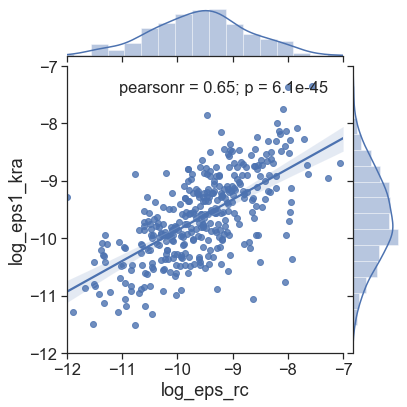

In [157]:
sns.jointplot(x='log_eps_rc',y='log_eps1_kra',data=ds, kind='reg',dropna=True, stat_func=pearsonr,
             xlim=(-12,-7),ylim=(-12,-7))

(1e-12, 1e-08)

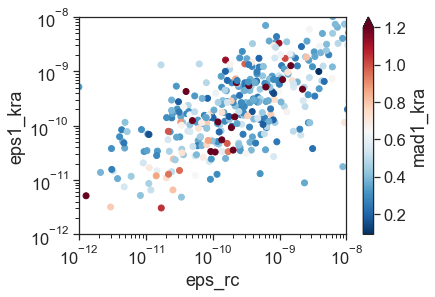

In [158]:
ds.plot.scatter(x='eps_rc',y='eps1_kra',hue='mad1_kra', vmax=1.2, cmap='RdBu_r')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-12,1e-8)
plt.ylim(1e-12,1e-8)

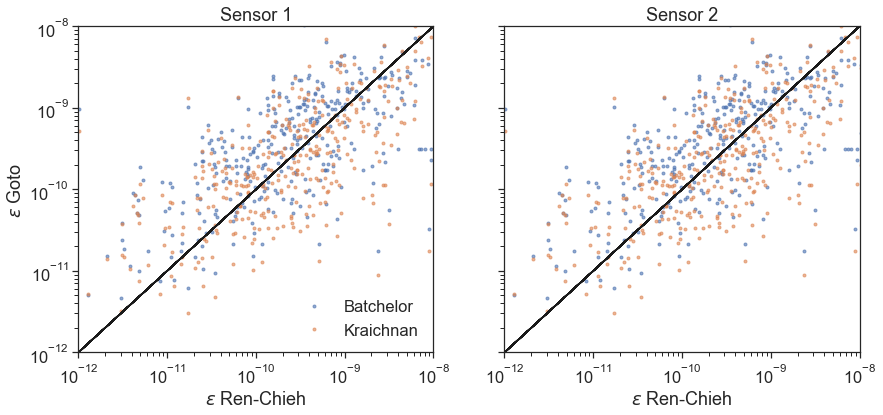

In [159]:
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
ax[0].plot( ds.eps_rc, ds.eps1_bat,'.',label='Batchelor', alpha=0.6)
ax[0].plot( ds.eps_rc, ds.eps1_kra,'.',label='Kraichnan', alpha=0.6)

ax[0].plot( ds.eps_rc, ds.eps_rc, color='k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(1e-12,1e-8)
ax[0].set_ylim(1e-12,1e-8)
ax[0].set_xlabel(r'$\epsilon$ Ren-Chieh')
ax[0].set_ylabel(r'$\epsilon$ Goto')
ax[0].set_title(r'Sensor 1')
ax[0].legend()

ax[1].plot( ds.eps_rc, ds.eps2_bat,'.',label='Batchelor', alpha=0.6)
ax[1].plot( ds.eps_rc, ds.eps2_kra,'.',label='Kraichnan', alpha=0.6)
ax[1].plot( ds.eps_rc, ds.eps_rc, color='k')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(1e-12,1e-8)
ax[1].set_ylim(1e-12,1e-8)
ax[1].set_xlabel(r'$\epsilon$ Ren-Chieh')
ax[1].set_title(r'Sensor 2')
plt.savefig('../figures/scatter_goto_vs_rc_2sensors.pdf')
plt.show()

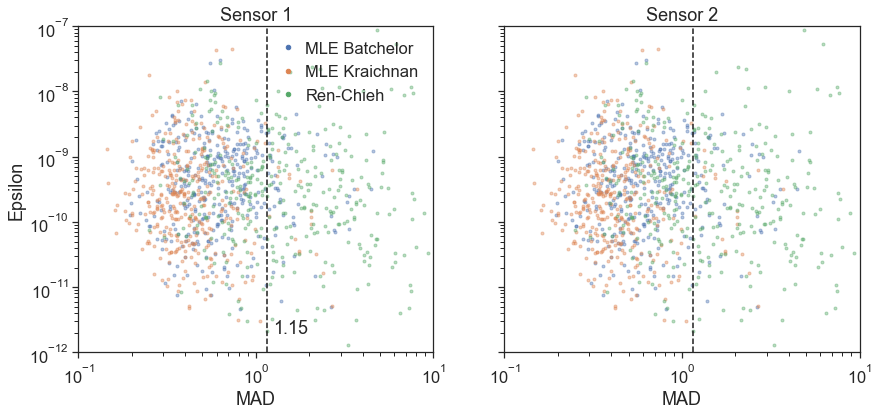

In [160]:
def plot_mad(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    if sensor==1:
        ax.plot( ds.mad1_bat, ds.eps1_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.mad1_kra, ds.eps1_kra,'.',label='MLE Kraichnan', alpha=0.4)
        ax.plot( ds.mad1_rc, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
        ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
        leg = ax.legend(handletextpad=0.05, markerscale=1.5)
        ax.set_ylabel(ylabel)
        for lh in leg.legendHandles: 
            lh._legmarker.set_alpha(1)
    elif sensor==2:
        ax.plot( ds.mad2_bat, ds.eps2_bat,'.',label='MLE Batchelor', alpha=0.4)
        ax.plot( ds.mad2_kra, ds.eps2_kra,'.',label='MLE Kraichnan', alpha=0.4)
        ax.plot( ds.mad2_rc, ds.eps_rc,'.',label='Ren-Chieh', alpha=0.4)
    else:
        raise ValueError('Only 2 sensors!')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-1,1e1)
    ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.axvline(mad_max, color='k', ls='dashed')
    
mad_max = 2*np.sqrt(2/6)
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
plot_mad(ax[0],ds,1,mad_max,'Sensor 1','Epsilon','MAD')
plot_mad(ax[1],ds,2,mad_max,'Sensor 2','Epsilon','MAD')

plt.savefig('../figures/scatter_mad_vs_eps_2sensors.pdf')
plt.show()

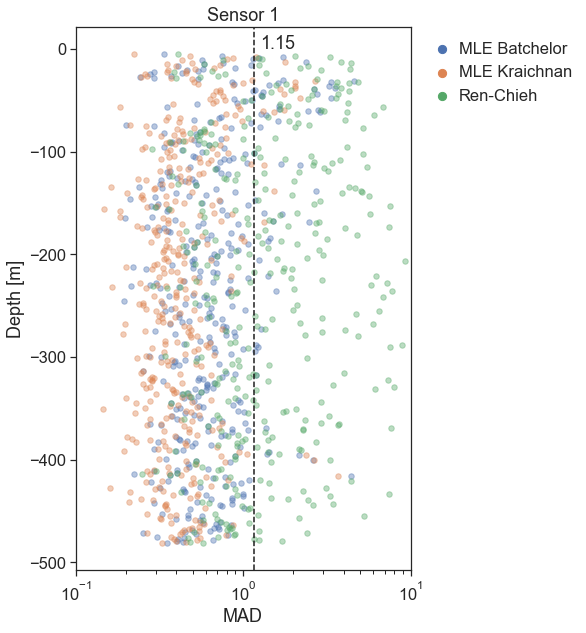

In [161]:
def scatter_mad_w_depth(ax,ds,sensor,mad_max,title,ylabel,xlabel):
    s=30
    if sensor==1:
        ax.scatter( ds.mad1_bat,ds.z,s,label='MLE Batchelor', alpha=0.4, color=None)
        ax.scatter( ds.mad1_kra,ds.z,s,label='MLE Kraichnan', alpha=0.4)
        ax.scatter( ds.mad1_rc,ds.z,s,label='Ren-Chieh', alpha=0.4)
        ax.annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12))
        leg = ax.legend(handletextpad=0.05, markerscale=1.5, loc='upper left',
               bbox_to_anchor=(1, 1))
        ax.set_ylabel(ylabel)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    elif sensor==2:
        ax.scatter( ds.mad2_bat,ds.z,s,label='MLE Batchelor', alpha=0.4)
        ax.scatter( ds.mad2_kra,ds.z,s,label='MLE Kraichnan', alpha=0.4)
        ax.scatter( ds.mad2_rc,ds.z,s,label='Ren-Chieh', alpha=0.4)
    else:
        raise ValueError('Only 2 sensors!')
#     ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-1,1e1)
#     ax.set_ylim(1e-12,1e-7)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.axvline(mad_max, color='k', ls='dashed')
    
mad_max = 2*np.sqrt(2/6)
f,ax = plt.subplots(1,1,figsize=(6,10), sharey =True)
scatter_mad_w_depth(ax,ds,1,mad_max,'Sensor 1','Depth [m]','MAD')
plt.savefig('../figures/scatter_mad_vs_depth.pdf')
plt.show()